In [1]:
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from actual import actual_effect
from IWLS import IWLS, adaptive_IWLS
from first_order import first_order
from margin import margin

In [2]:
# general parameters
n, k = 50, 5

seed = 23
cov = 0.5

target = "probability"
np.random.seed(seed)

In [3]:
# generate data
mean_n = np.array([-1, 0])
mean_p = np.array([1, 0])
covariance = np.eye(2) * cov
x_n = np.random.multivariate_normal(mean_n, covariance, int(n/2))
x_p = np.random.multivariate_normal(mean_p, covariance, int(n/2))

y_n = np.zeros(int(n/2)) # 0 labels
y_p = np.ones(int(n/2))  # 1 labels

X_train = np.vstack((x_n, x_p))
y_train = np.hstack((y_n, y_p))

# Choose mean_n or mean_p w.p. 1/2
if np.random.rand() < 0.5:
	x_test = np.random.multivariate_normal(mean_n, covariance)
	y_test = 0
else:
	x_test = np.random.multivariate_normal(mean_p, covariance)
	y_test = 1

logistic_classifier = LogisticRegression(penalty=None).fit(X_train, y_train)
print(y_test)

1


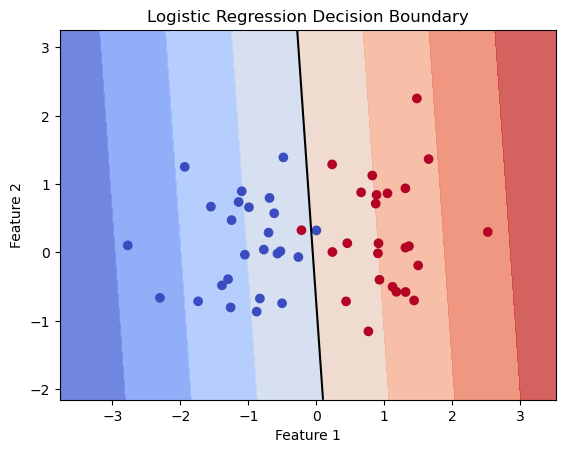

In [4]:
# Plot the decision boundary
xx, yy = np.meshgrid(np.linspace(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 100),
                    np.linspace(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1, 100))
Z = logistic_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.contour(xx, yy, Z, colors='black', linestyles='-', levels=[0])
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Logistic Regression Decision Boundary')
plt.show()

In [5]:
def read_best_k_subset(file_path):
    # Initialize an empty list to store the best k subset
    best_k_subset = []

    # Open the file and read line by line
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Use regular expressions to find and extract the best k subset
    pattern = re.compile(r'size 5: \[([\d\s]+)\]')
    for line in lines:
        match = pattern.search(line)
        if match:
            # Extract numbers from the matched group and convert to a list of integers
            numbers_str = match.group(1)
            best_k_subset = list(map(int, numbers_str.split()))

            # Break the loop once the information is found
            break

    return best_k_subset

In [6]:
# Best Subset
file_path = f"results/target={target}/s={seed}_n={n}_k={k}_cov={cov}.txt"
best_k_subset = read_best_k_subset(file_path)

ind_n, ind_p = margin(X_train, y_train)

estimated_best_k_subset = {
    "Brute Force": best_k_subset,
    "IWLS": IWLS(X_train, y_train, x_test, y_test, target=target)[:k],
    "AIWLS": adaptive_IWLS(X_train, y_train, x_test, y_test, k=k, target=target),
    "FO": first_order(X_train, y_train, x_test, y_test, target=target)[:k],
    "Margin N": ind_n[:k], 
    "Margin P": ind_p[:k]
}

In [7]:
# Iterate over the methods and plot in the corresponding subplot
methods = ["Brute Force", "IWLS", "AIWLS", "FO", "Margin N", "Margin P"]

for method in methods:
    print(method)
    print(estimated_best_k_subset[method], actual_effect(X_train, y_train, x_test, y_test, estimated_best_k_subset[method], 0, target=target))

Brute Force
[15, 18, 23, 30, 32] 0.9999999998147588
IWLS
[15 23 49  2  0] 0.9999999682476705
AIWLS
[15 25 26 27 28] 0.8414209757963458
FO
[15 16 42  8 11] 6.960157218554454e-12
Margin N
[15 23 16  0  2] 0.9999797714838372
Margin P
[48 34 49 42 47] 1.0117915001679398e-06


# Plot

In [8]:
def most_influential_subset_plot(X_train, y_train, x_test, y_test, estimated_best_k_subset, method, ax):
    xx, yy = np.meshgrid(np.linspace(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1, 100),
                    np.linspace(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1, 100))
    
    # Plot the decision boundary of the original model (dashed line)
    logistic_classifier = LogisticRegression(penalty=None).fit(X_train, y_train)
    original_Z = logistic_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contour(xx, yy, original_Z, colors='black', linestyles='--', levels=[0])

    if target == "probability":
        original_score = logistic_classifier.predict_proba(x_test.reshape(1, -1))[0][1] # We're looking at the predicted probability of the positive class
    elif target == "train_loss":
        original_score = log_loss(y_train, logistic_classifier.predict_proba(X_train), labels=[0, 1])
    elif target == "test_loss":
        original_score = log_loss([y_test], logistic_classifier.predict_proba(x_test.reshape(1, -1)), labels=[0, 1])

    score = actual_effect(X_train, y_train, x_test, y_test, estimated_best_k_subset[method], original_score, target=target)

    # Plot the decision boundary of the reduced model (solid line) 
    reduced_X_train = np.delete(X_train, estimated_best_k_subset[method], axis=0)
    reduced_y_train = np.delete(y_train, estimated_best_k_subset[method], axis=0)
    reduced_logistic_classifier = LogisticRegression(penalty=None).fit(reduced_X_train, reduced_y_train)
    reduced_Z = reduced_logistic_classifier.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, reduced_Z, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.contour(xx, yy, reduced_Z, colors='black', linestyles='-', levels=[0])

    # Mark the dataset points with a marker ('o' symbol)
    reduced_X_train = np.delete(X_train, estimated_best_k_subset["Brute Force"], axis=0)
    reduced_y_train = np.delete(y_train, estimated_best_k_subset["Brute Force"], axis=0)
    ax.scatter(reduced_X_train[:, 0], reduced_X_train[:, 1], c=reduced_y_train, cmap=plt.cm.coolwarm, marker='o')
    # ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.coolwarm, marker='o')

    # Mark the test point with a marker ('s' symbol)
    ax.scatter(x_test[0], x_test[1], c='#ae4cee', marker='s', s=20, label="Test Point")
    
    # Mark the best subset of removed data points with a different marker ('o' symbol)
    best_subset_points = np.take(X_train, estimated_best_k_subset["Brute Force"], axis=0).reshape(-1, 2)
    ax.scatter(best_subset_points[:, 0], best_subset_points[:, 1], c='#12afc2', marker='o', label="Best Subset")

    # Mark the estimated best subset of removed data points with a different marker ('x' symbol)
    if method == "Brute Force":
        ax.set_title(f"Best Subset. Score: {score:.6f}")
    if method == "IWLS":
        IWLS_best_k_points = np.take(X_train, estimated_best_k_subset[method], axis=0).reshape(-1, 2)
        ax.scatter(IWLS_best_k_points[:, 0], IWLS_best_k_points[:, 1], c='#ff6a88', marker='x', s=70, label="IWLS")
        ax.set_title(f"IWLS. Score: {score:.6f}")
    elif method == "AIWLS":
        adaptive_IWLS_best_k_points = np.take(X_train, estimated_best_k_subset[method], axis=0).reshape(-1, 2)
        ax.scatter(adaptive_IWLS_best_k_points[:, 0], adaptive_IWLS_best_k_points[:, 1], c='#ff6a88', marker='x', s=70, label="Adaptive IWLS")
        ax.set_title(f"Adaptive IWLS. Score: {score:.6f}")
    elif method == "FO":
        FO_best_k_points = np.take(X_train, estimated_best_k_subset[method], axis=0).reshape(-1, 2)
        ax.scatter(FO_best_k_points[:, 0], FO_best_k_points[:, 1], c='#ff6a88', marker='x', s=70, label="First-Order")
        ax.set_title(f"First-Order. Score: {score:.6f}")
    elif method == "Margin N":
        margin_n_best_k_points = np.take(X_train, estimated_best_k_subset[method], axis=0).reshape(-1, 2)
        ax.scatter(margin_n_best_k_points[:, 0], margin_n_best_k_points[:, 1], c='#ff6a88', marker='x', s=70, label="Margin (N)")
        ax.set_title(f"Margin (N). Score: {score:.6f}")
    elif method == "Margin P":
        margin_n_best_k_points = np.take(X_train, estimated_best_k_subset[method], axis=0).reshape(-1, 2)
        ax.scatter(margin_n_best_k_points[:, 0], margin_n_best_k_points[:, 1], c='#ff6a88', marker='x', s=70, label="Margin (P)")
        ax.set_title(f"Margin (P). Score: {score:.6f}")

    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    # Add legend inside each subplot
    ax.legend()

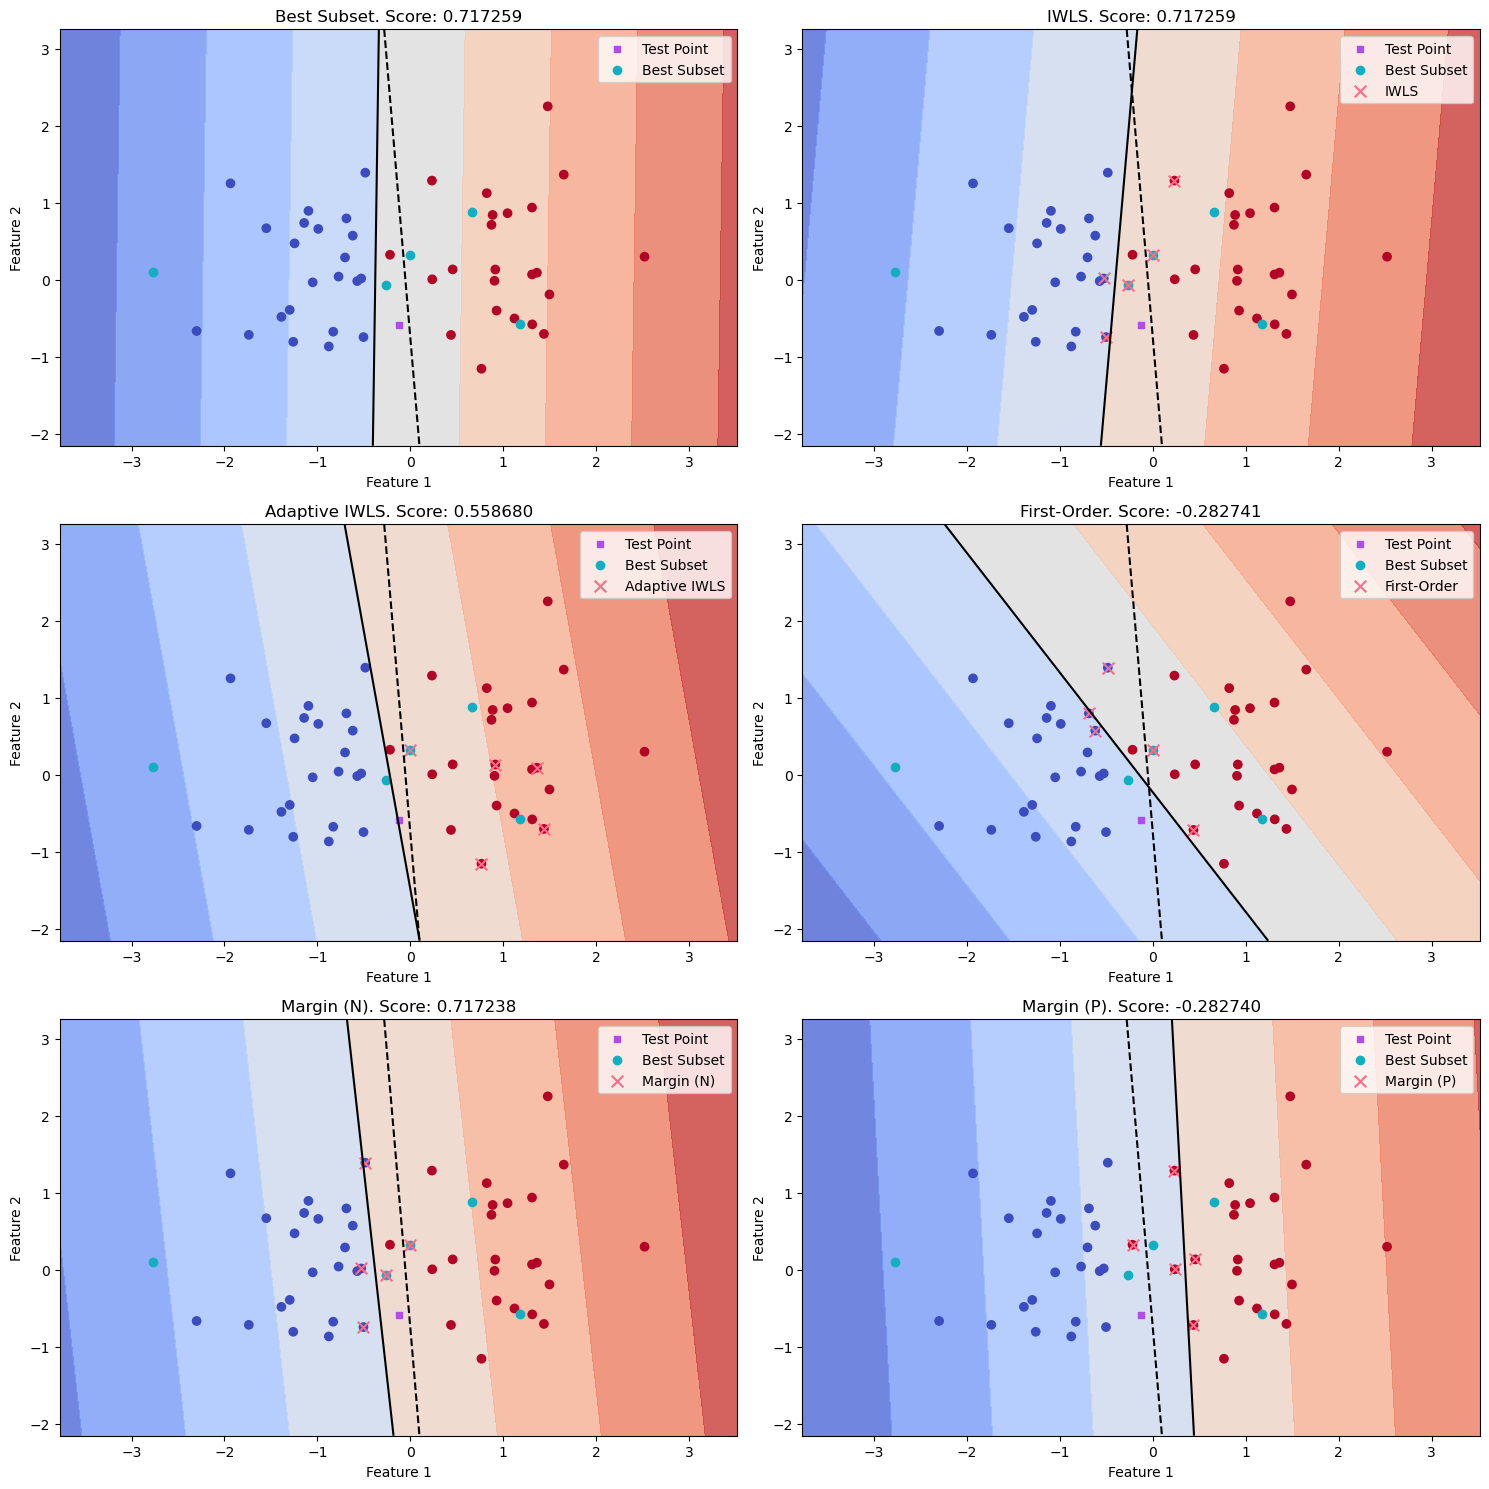

In [9]:
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

for i, method in enumerate(methods):
    row = i // 2
    col = i % 2
    most_influential_subset_plot(X_train, y_train, x_test, y_test, estimated_best_k_subset, method=method, ax=axs[row, col])

# Adjust layout for better spacing
plt.tight_layout()

# Show the figure
plt.show()